In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
!unzip /content/drive/MyDrive/plant.zip > /dev/null

In [4]:
data_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = '/content/test/test'
diseases = os.listdir(train_dir)
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 43


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

original_dataset_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Blackgram_healthy'

augmented_dataset_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Blackgram_healthy'

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

file_list = os.listdir(original_dataset_dir)

for filename in file_list:
    img = load_img(os.path.join(original_dataset_dir, filename))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    for batch in datagen.flow(x, batch_size=1):
        augmented_img = array_to_img(batch[0], scale=True)
        augmented_img.save(os.path.join(augmented_dataset_dir, f'augmented_{filename[:-4]}_{i}.jpg'))
        i += 1
        if i >= 13:
            break

,no. of images
Tomato___Target_Spot,1827
Blackgram_Yellow_Mosaic,1876
Potato___Late_blight,1939
Grape___healthy,1692
Blackgram_Powdery_Mildew_180,1728
Tomato___Early_blight,1920
Squash___Powdery_mildew,1736
Tomato___Septoria_leaf_spot,1745
Potato___healthy,1824
Orange___Haunglongbing_(Citrus_greening),2010


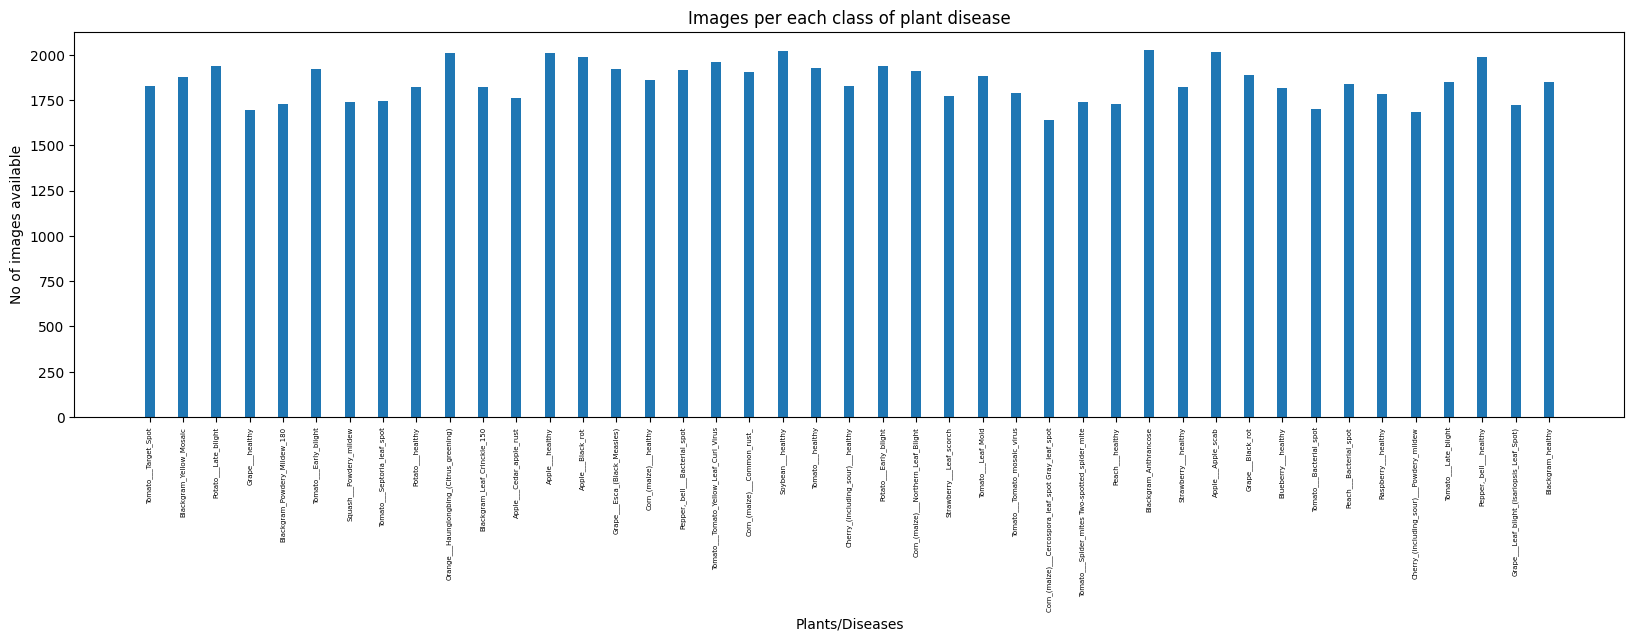

In [8]:
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
index = [n for n in range(43)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

In [6]:
import os
from collections import defaultdict

max_images_per_class = 500
classes_to_consider = 5
classes_to_limit = ['Blackgram_Anthrancose', 'Blackgram_Leaf_Crinckle_150', 'Blackgram_Powdery_Mildew_180', 'Blackgram_Yellow_Mosaic', 'Blackgram_healthy']

class_count = defaultdict(int)
classes_considered = 0

for class_name in classes_to_limit:
    class_dir = os.path.join(valid_dir, class_name)
    if os.path.exists(class_dir):
        files = os.listdir(class_dir)
        files.sort()
        if len(files) > max_images_per_class:
            excess = len(files) - max_images_per_class
            for i in range(excess):
                os.remove(os.path.join(class_dir, files[i]))

        classes_considered += 1

    if classes_considered >= classes_to_consider:
        break


In [9]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=43)

94765736/94765736 [==============================] - 0s 0us/step


In [10]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func)
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Flatten()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=BatchNormalization()(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=BatchNormalization()(model_resnet)
model_resnet=Dense(43,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)

val_datagen=ImageDataGenerator()

train= train_datagen.flow_from_directory(directory=train_dir,batch_size=32,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=42)

valid=val_datagen.flow_from_directory(directory=valid_dir,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical',seed=42)

Found 79591 images belonging to 43 classes.
Found 20072 images belonging to 43 classes.


In [12]:
es = EarlyStopping(monitor='val_accuracy',verbose=1,patience=7,mode='auto')
mc = ModelCheckpoint(filepath='/content/cnn',monitor='val_accuracy',verbose=1,save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=5,min_lr=0.001)

In [13]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
model_main.fit(train,validation_data=valid,epochs=30,steps_per_epoch=200,verbose=1,callbacks=[mc,es,lr])

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 1.4517 - accuracy: 0.6748
Epoch 1: val_accuracy improved from -inf to 0.84366, saving model to /content/cnn
200/200 [==============================] - 193s 913ms/step - loss: 1.4517 - accuracy: 0.6748 - val_loss: 0.6589 - val_accuracy: 0.8437 - lr: 0.0010
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.4915 - accuracy: 0.8905
Epoch 2: val_accuracy improved from 0.84366 to 0.89099, saving model to /content/cnn
200/200 [==============================] - 198s 993ms/step - loss: 0.4915 - accuracy: 0.8905 - val_loss: 0.3788 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.3191 - accuracy: 0.9172
Epoch 3: val_accuracy improved from 0.89099 to 0.92911, saving model to /content/cnn
200/200 [==============================] - 180s 903ms/step - loss: 0.3191 - accuracy: 0.9172 - val_loss: 0.2570 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 4/30
200/2

In [ ]:
model_main.save("resnetcantgetbetter.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
